# Bayesian Optimization using inferred model

In [1]:
%matplotlib inline
import functools
import numpy as np
from theano import theano, tensor as tt
import matplotlib.pyplot as plt
import pymc3 as pm
theano.config.floatX = 'float64'
np.random.seed(42)

Consider a simple quadratic problem with unknown parameters

In [2]:
def f(x, a, b, c):
    return a*x**2 + b*x + c

Generate true data

In [3]:
x_obs = np.random.uniform(-5, 5, size=(15,))
a, b, c = 1, 2, 3
min_ = np.array([-b/2/a])
y_obs = f(x_obs, a, b, c) + np.random.normal(size=x_obs.shape)

Let's see true minima

In [4]:
min_

array([-1.])

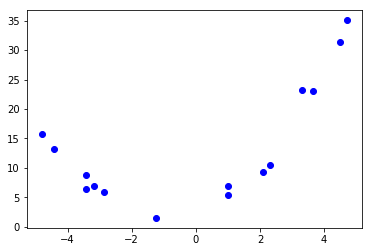

In [5]:
plt.plot(x_obs, y_obs, 'bo');

In [6]:
sgd = functools.partial(pm.sgd, learning_rate=1) # simple problem - simple optimizer
with pm.Model():
    abc = pm.Normal('abc', sd=1, shape=(3,))
    x = theano.shared(x_obs, 'x_obs')
    x2 = x**2
    o = tt.ones_like(x)
    X = tt.stack([x2, x, o]).T
    y = X.dot(abc)
    pm.Normal('y', mu=y, observed=y_obs)
    trace = pm.svgd(n=100, optimizer=sgd)
    approx = pm.Histogram(trace)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 100/100 [00:00<00:00, 177.56it/s]


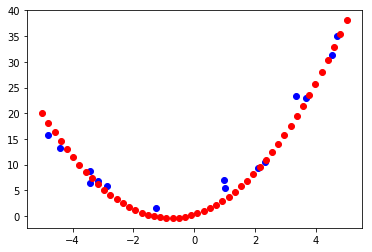

In [7]:
x.set_value(np.linspace(-5, 5))
plt.plot(x_obs, y_obs, 'bo');
plt.plot(np.linspace(-5, 5), approx.apply_replacements(y, deterministic=True).eval(), 'ro');

In [10]:
sgd = functools.partial(pm.sgd, learning_rate=.1)
x.set_value(np.zeros((1,)))
opt = pm.Optimizer(approx, y.sum(), [x], optimizer=sgd)
opt.fit(1500)

E_q[Loss] = -0.3817: 100%|██████████| 1500/1500 [00:00<00:00, 14711.59it/s]


In [11]:
x.get_value()

array([-0.72910345])